# Step 1: Import helpful libraries

In [ ]:
# Importing Libraries
import pandas as pd # Intermediate DS
import numpy as np # Scientific Operations
import copy

from sklearn import preprocessing # Preprocesing library for Encoding, etc.
from sklearn.model_selection import KFold # Segregating the train data to fragments for predorming Cross Validation
from sklearn.metrics import mean_squared_error # For Calculating Mean Squared Error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb # Light GBM Regressor

from datetime import datetime # For storing date and timers for operations

import warnings
warnings.filterwarnings('ignore')

# Step 2: Load the data

Next, we'll load the training and test data.  

In [ ]:
# Load the training data
train = pd.read_csv("../input/30-days-of-ml/train.csv", index_col=0)
test = pd.read_csv("../input/30-days-of-ml/test.csv", index_col=0)

# Preview the data
train.head()
test.head()

The next code cell separates the target (which we assign to y) from the training features.

In [ ]:
y_train = train.target
X_train = train.drop(['target'], axis=1)
X_test = test.copy()

# Preview features
X_train.head()

# Blending Optimization Condition 1

Ordinal Encoder - Categorical Columns

In [ ]:
# # Extract the Categorical Columns
# cat_cols = [feature for feature in train.columns if 'cat' in feature]
# print(cat_cols)

# # Copy of original data to prevent overwwritting them
# label_X_train = X_train.copy()
# label_X_test = X_test.copy()

# # Apply ordinal encoder to each column with categorical data
# ord_encoder = preprocessing.OrdinalEncoder()
# label_X_train[cat_cols] = ord_encoder.fit_transform(label_X_train[cat_cols])
# label_X_test[cat_cols] = ord_encoder.transform(label_X_test[cat_cols])

# del ord_encoder

# Blending Optimization Condition 2
OH Encoder - Low Cardinality Categorical Columns

Ordinal Encoder - High Cardinality Categorical Columns

In [ ]:
# Extract the Categorical Columns
cat_cols = [feature for feature in X_train.columns if 'cat' in feature]
print(cat_cols)
low_cardinality_cols = [col for col in cat_cols if X_train[col].nunique() < 8]
print(low_cardinality_cols)
high_cardinality_cols = list(set(cat_cols) - set(low_cardinality_cols))
print(high_cardinality_cols)

# Copy of original data to prevent overwwritting them
label_X_train = X_train.copy()
label_X_test = X_test.copy()

print('Original Train Shape: %s' %str(label_X_train.shape))
print('Original Test Shape: %s' %str(label_X_test.shape))

'''
One Hot Encoding for low cardinality cols
'''
OH_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

OH_cols_X = pd.DataFrame(OH_encoder.fit_transform(label_X_train[low_cardinality_cols]))
OH_cols_X_test = pd.DataFrame(OH_encoder.fit_transform(label_X_test[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_X.index = label_X_train.index
OH_cols_X_test.index = label_X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X = label_X_train.drop(low_cardinality_cols, axis=1)
num_X_test = label_X_test.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
label_X_train = pd.concat([num_X, OH_cols_X], axis=1)
label_X_test = pd.concat([num_X_test, OH_cols_X_test], axis=1)

print('Train Shape After OH Encoding: %s' %str(label_X_train.shape))
print('Test Shape After OH Encoding: %s' %str(label_X_test.shape))

'''
Ordinal Encoding for high cardinality cols
'''
ord_encoder = preprocessing.OrdinalEncoder()

label_X_train[high_cardinality_cols] = ord_encoder.fit_transform(label_X_train[high_cardinality_cols])
label_X_test[high_cardinality_cols] = ord_encoder.fit_transform(label_X_test[high_cardinality_cols])

print('Train Shape After Ordinal Encoding: %s' %str(label_X_train.shape))
print('Test Shape After Ordinal Encoding: %s' %str(label_X_test.shape))

del OH_encoder, OH_cols_X, OH_cols_X_test, num_X, num_X_test
del ord_encoder

# Blending Optimization Condition 3
OH Encoder - Low Cardinality Categorical Columns

Ordinal Encoder - High Cardinality Categorical Columns

Polynomial Encoder - Numerical Columns

In [ ]:
# # Extract the Categorical Columns
# cat_cols = [feature for feature in X_train.columns if 'cat' in feature]
# print(cat_cols)
# low_cardinality_cols = [col for col in cat_cols if X_train[col].nunique() < 8]
# print(low_cardinality_cols)
# high_cardinality_cols = list(set(cat_cols) - set(low_cardinality_cols))
# print(high_cardinality_cols)
# numerical_cols = [feature for feature in X_train.columns if feature.startswith("cont")]
# print(numerical_cols)

# # Copy of original data to prevent overwwritting them
# label_X_train = X_train.copy()
# label_X_test = X_test.copy()

# print('Original Train Shape: %s' %str(label_X_train.shape))
# print('Original Test Shape: %s' %str(label_X_test.shape))

# '''
# Polynomial Encoding for numerical cols
# '''
# poly = preprocessing.PolynomialFeatures(degree=3, interaction_only=True, include_bias=False)

# train_poly = poly.fit_transform(label_X_train[numerical_cols])
# test_poly = poly.fit_transform(label_X_test[numerical_cols])

# df_poly = pd.DataFrame(train_poly, columns=[f"poly_{i}" for i in range(train_poly.shape[1])])
# df_test_poly = pd.DataFrame(test_poly, columns=[f"poly_{i}" for i in range(test_poly.shape[1])])

# df_poly['id'] = list(label_X_train.index)
# df_test_poly['id'] = list(label_X_test.index)
# df_poly = df_poly.set_index('id')
# df_test_poly = df_test_poly.set_index('id')

# label_X_train = pd.concat([label_X_train, df_poly], axis=1)
# label_X_test = pd.concat([label_X_test, df_test_poly], axis=1)

# print('Train Shape After Polynomial Encoding: %s' %str(label_X_train.shape))
# print('Test Shape After Polynomial Encoding: %s' %str(label_X_test.shape))

# '''
# One Hot Encoding for low cardinality cols
# '''
# OH_encoder = preprocessing.OneHotEncoder(handle_unknown='ignore', sparse=False)

# OH_cols_X = pd.DataFrame(OH_encoder.fit_transform(label_X_train[low_cardinality_cols]))
# OH_cols_X_test = pd.DataFrame(OH_encoder.fit_transform(label_X_test[low_cardinality_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_X.index = label_X_train.index
# OH_cols_X_test.index = label_X_test.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X = label_X_train.drop(low_cardinality_cols, axis=1)
# num_X_test = label_X_test.drop(low_cardinality_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# label_X_train = pd.concat([num_X, OH_cols_X], axis=1)
# label_X_test = pd.concat([num_X_test, OH_cols_X_test], axis=1)

# print('Train Shape After OH Encoding: %s' %str(label_X_train.shape))
# print('Test Shape After OH Encoding: %s' %str(label_X_test.shape))

# '''
# Ordinal Encoding for high cardinality cols
# '''
# ord_encoder = preprocessing.OrdinalEncoder()

# label_X_train[high_cardinality_cols] = ord_encoder.fit_transform(label_X_train[high_cardinality_cols])
# label_X_test[high_cardinality_cols] = ord_encoder.fit_transform(label_X_test[high_cardinality_cols])

# print('Train Shape After Ordinal Encoding: %s' %str(label_X_train.shape))
# print('Test Shape After Ordinal Encoding: %s' %str(label_X_test.shape))

# del poly, train_poly, test_poly, df_poly, df_test_poly
# del OH_encoder, OH_cols_X, OH_cols_X_test, num_X, num_X_test
# del ord_encoder

In [ ]:
label_X_train.head()

In [ ]:
y_train.head()

In [ ]:
label_X_test.head()

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# label_X_train = reduce_mem_usage(label_X_train)
# label_X_test = reduce_mem_usage(label_X_test)

# Step 3: Optimize the XG Boost Classifier

In [ ]:
!nvidia-smi

In [ ]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [ ]:
# Hyper Parameter Optimization
xgb_params={
    'learning_rate'    : [0.003, 0.05, 0.10, 0.15],
    'max_depth'        : [3, 4, 5],
    'min_child_weight' : [1, 1.5, 3, 5, 7 ],
    'gamma'            : [0.0, 0.1, 0.2 , 0.3, 0.4 ],
    'colsample_bytree' : [0.1, 0.3, 0.4, 0.5 , 0.7 ],
    'n_estimators'     : [1000, 1500, 2000, 2500, 3500, 4000, 5000, 10000],
    'reg_lambda'       : [5, 10, 15, 20, 25, 30, 40, 50],
    'reg_alpha'        : [5, 10, 15, 20, 25, 30, 40, 50],
}

In [ ]:
split = KFold(n_splits=10, random_state=91, shuffle=True)

xgb_regressor=xgb.XGBRegressor(random_state=91, 
                               tree_method='gpu_hist', 
                               nthread=1)
random_search=RandomizedSearchCV(xgb_regressor,
                                 param_distributions=xgb_params,
                                 n_iter=50,
                                 scoring='neg_root_mean_squared_error',
                                 n_jobs=-1,
                                 cv=split.split(label_X_train, y_train),
                                 verbose=3)
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(label_X_train, y_train)
timer(start_time) # timing ends here for "start_time" variable

## Condition 1: Run with Ordinal Encoder only for Categorical Columns
10k fold split with random state as 91 and n_iter for RandomizeedSearchCV being 50

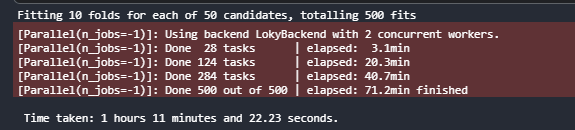

## Condition 2: Run with Ordinal Encoder for high cardinality columns and OH Encoder for low cardinality columns

10k fold split with random state as 91 and n_iter for RandomozedSearchCV being 50

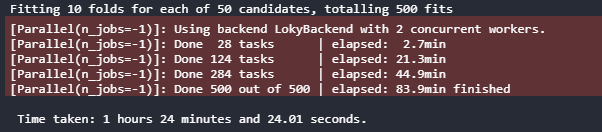

## Condition 3: Run with Ordinal Encoder for high cardinality columns, OH Encoder for low cardinality columns and polynomial Encoder for numerical colums
10k fold split with random state as 91 and n_iter for RandomizeedSearchCV being 10

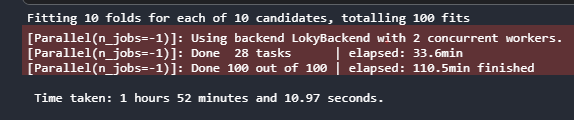

In [ ]:
random_search.best_estimator_

## Condition 1: Best Regressor with Ordinal Encoder only for Categorical Columns
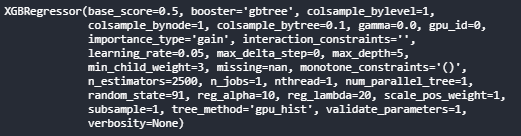

## Condition 2: Best Regressor with Ordinal Encoder for high cardinality columns and OH Encoder for low cardinality columns 

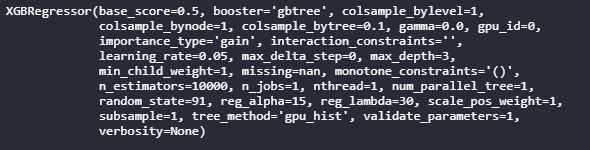

## Condition 3: Best Regressor with Ordinal Encoder for high cardinality columns, OH Encoder for low cardinality columns and polynomial Encoder for numerical colums

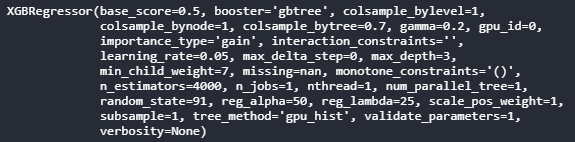

In [ ]:
random_search.best_params_

In [ ]:
'''
CONDITION 1
Optimized Hyper Parameters for RandomizedSearchCV on Training Dataset where Categorical columns 
are converted to Ordinal Columns
'''
optimized_xgb_params={
    'colsample_bytree': 0.1, 
    'gamma': 0.0, 
    'learning_rate': 0.15, 
    'max_depth': 5,
    'min_child_weight': 3, 
    'n_estimators': 2500,
    'n_jobs': -1, 
    'random_state': 91, 
    'reg_alpha': 10, 
    'reg_lambda': 20, 
    #'nthread': 1, 
    #'tree_method': 'gpu_hist', 
}

'''
CONDITION 2
ptimized Hyper Parameters for RandomizedSearchCV on Training Dataset where Categorical columns 
are converted to Ordinal Columns for high cardinality columns, Categorical columns are converted 
to One Hot Columns for low cardinality columns
'''
optimized_xgb_params={
    'colsample_bytree': 0.1, 
    'gamma': 0.0, 
    'learning_rate': 0.05, 
    'max_depth': 3,
    'min_child_weight': 1, 
    'n_estimators': 10000,
    'n_jobs': -1, 
    'random_state': 91, 
    'reg_alpha': 15, 
    'reg_lambda': 30, 
    #'nthread': 1, 
    #'tree_method': 'gpu_hist', 
}

'''
CONDITION 3
Optimized Hyper Parameters for RandomizedSearchCV on Training Dataset where Categorical columns 
are converted to Ordinal Columns for high cardinality columns, Categorical columns are converted 
to One Hot Columns for low cardinality columns and Numerical columns are converted to Polynomial 
columns
'''
optimized_xgb_params={
    'colsample_bytree': 0.7, 
    'gamma': 0.2, 
    'learning_rate': 0.05, 
    'max_depth': 3,
    'min_child_weight': 7, 
    'n_estimators': 4000,
    'n_jobs': -1, 
    'random_state': 91, 
    'reg_alpha': 50, 
    'reg_lambda': 25, 
    'nthread': 1, 
    'tree_method': 'gpu_hist', 
}